In [1]:
#Importing all
!pip install langid
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, split, udf
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.linalg import Vectors, SparseVector
import numpy as np
import langid
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, lower, regexp_replace, split
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql import DataFrame
# from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorSlicer

In [2]:
# spark = SparkSession.builder \
#     .appName("Project 3") \
#     .getOrCreate()

In [3]:
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

In [4]:
!unzip -u dblp.v10.zip

Archive:  dblp.v10.zip


In [5]:
# df = spark.read.json("./dblp-ref/*.json", multiLine=True)
# df = spark.read.json("./dblp-ref/dblp-ref-0.json")

In [25]:
from functools import reduce

# List of file paths
file_paths = ["./dblp-ref/dblp-ref-0.json", "./dblp-ref/dblp-ref-1.json", "./dblp-ref/dblp-ref-2.json", "./dblp-ref/dblp-ref-3.json"]

# Read data from all JSON files
dfs = [spark.read.json(file_path) for file_path in file_paths]

# Combine all DataFrames into one
df_combined = reduce(lambda df1, df2: df1.union(df2), dfs)

# Show the combined DataFrame
df_combined.show(5)  # Show the first 5 rows to verify the data


+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|
|This paper descri...|[Gareth Beale, Gr...|001c58d3-26ad-46b...|        50|[10482dd3-4642-41...|A methodology for...|visual analytics ...|2011|
|This article appl...|[Altaf Hossain, F...|001c8744-73c4-4b0...|        50|[2d84c0f2-e656-4c...|Comparison of GAR...|pattern recogniti...|2009|
|                NULL|[Jea-Bum Park, By...|00338203-9eb3-40c...|         0|[8c78e4b0-632b-42...|Development of Re...|                   

In [26]:
# Show the schema
df.printSchema()
df.show(5)
print(f"Number of records: {df.count()}")

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)
 |-- language: string (nullable = true)

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Pr

In [7]:
# Display summary statistics
df.describe().show()

# Check for missing values (excluding `isnan`)
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Distribution of citations
df.select("n_citation").describe().show()

# Check for null abstracts and titles
df.filter(df.abstract.isNull() | df.title.isNull()).show()

+-------+--------------------+--------------------+------------------+-------------------------------------+--------------------+----------------+
|summary|            abstract|                  id|        n_citation|                                title|               venue|            year|
+-------+--------------------+--------------------+------------------+-------------------------------------+--------------------+----------------+
|  count|              753646|             1000000|           1000000|                              1000000|             1000000|         1000000|
|   mean|                NULL|                NULL|          30.87573|                                 NULL|                NULL|     2006.365124|
| stddev|                NULL|                NULL|137.94247310778852|                                 NULL|                NULL|7.83383289543257|
|    min| ...|000000b8-7f59-49a...|                 0|                 ! and ? – Storage...|          

In [8]:
# Function to detect language using langid
def detect_language(text):
    if text is None:
        return None
    lang, _ = langid.classify(text)
    return lang

# Registering UDF
lang_detect_udf = udf(detect_language, StringType())

# Add a new column for language detection
df = df.withColumn("language", lang_detect_udf(df.abstract))

# Filter only English documents
df = df.filter(df.language == 'en')
df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|      en|
|This paper descri...|[Gareth Beale, Gr...|001c58d3-26ad-46b...|        50|[10482dd3-4642-41...|A methodology for...|visual analytics ...|2011|      en|
|This article appl...|[Altaf Hossain, F...|001c8744-73c4-4b0...|        50|[2d84c0f2-e656-4c...|Comparison of GAR...|pattern recogniti...|2009|      en|
|Recent achievemen...|[Ankita Brahmacha...|00a119c4-d367-460...|         0|[84d471

In [9]:
# Custom stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 
                     'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 
                     'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 
                     'CZI', 'www']

In [10]:
# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))
# df_cleaned.show()

In [11]:
# Tokenize the text
df_tokenized = df_cleaned.withColumn("tokenized_abstract", split(col("cleaned_abstract"), " "))

In [12]:
# Remove stop words
remover = StopWordsRemover(inputCol="tokenized_abstract", outputCol="filtered_abstract", 
                           stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

In [13]:
# Show the cleaned dataframe
# df_filtered.select("abstract", "cleaned_abstract", "tokenized_abstract", "filtered_abstract").show(truncate=False)

In [14]:
# Apply TF
hashingTF = HashingTF(inputCol="filtered_abstract", outputCol="rawFeatures", numFeatures=20000)
df_featurized = hashingTF.transform(df_filtered)
# df_featurized.show()

In [15]:
# Apply IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(df_featurized)
df_vectorized = idf_model.transform(df_featurized)
df_vectorized.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|    cleaned_abstract|  tokenized_abstract|   filtered_abstract|         rawFeatures|            features|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|      en|the purpose of th...|[the, purpose, of...|[purpose, study, ...|(20000,[107

In [16]:
# Select only the columns we need
df_vectorized = df_vectorized.select("id", "title", "features")
df_vectorized.show(5)

+--------------------+--------------------+--------------------+
|                  id|               title|            features|
+--------------------+--------------------+--------------------+
|00127ee2-cb05-48c...|Preliminary Desig...|(20000,[1072,1241...|
|001c58d3-26ad-46b...|A methodology for...|(20000,[273,313,3...|
|001c8744-73c4-4b0...|Comparison of GAR...|(20000,[45,1188,1...|
|00a119c4-d367-460...|Identifying Psych...|(20000,[86,274,32...|
|00bcf2d5-1592-46b...|Multisymplectic S...|(20000,[1695,2431...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [17]:
#Clustering 

def sample_data(df, fraction, max_attempts=5):
    attempt = 0
    sampled_df = df.sample(fraction=fraction, seed=42)
    while sampled_df.count() == 0 and attempt < max_attempts:
        fraction *= 2  # Increase fraction to get more data
        sampled_df = df.sample(fraction=fraction, seed=42)
        attempt += 1
    if sampled_df.count() == 0:
        raise ValueError("Sampled DataFrame is empty after several attempts.")
    return sampled_df

# Sample the data with initial fraction 0.1
df_sampled = sample_data(df_vectorized, 0.1)
print(df_sampled)
print(f"Sampled DataFrame count: {df_sampled.count()}")
df_sampled.show(5)


DataFrame[id: string, title: string, features: vector]
Sampled DataFrame count: 74989
+--------------------+--------------------+--------------------+
|                  id|               title|            features|
+--------------------+--------------------+--------------------+
|00dd5ece-1339-4cb...|Knowledge Enginee...|(20000,[1239,1456...|
|01edeac9-cd8b-46f...|Information Syste...|(20000,[1463,1913...|
|028d37c8-b571-41b...|Automated Object ...|(20000,[23,32,45,...|
|0a2f9484-9355-4a2...|A Distributed Dyn...|(20000,[6,546,793...|
|0b3eeeaa-7422-462...|On Lascar rank in...|(20000,[133,740,9...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [18]:

# # Check if df_sampled is a Spark DataFrame
# if isinstance(df_sampled, DataFrame):
#     print("df_sampled is a Spark DataFrame")
# else:
#     print("df_sampled is not a Spark DataFrame")

# # Check if df_sampled has a column named "features"
# if "features" in df_sampled.columns:
#     print("df_sampled has a column named 'features'")
# else:
#     print("df_sampled does not have a column named 'features'")

In [19]:
# Use VectorSlicer to select relevant features
slicer = VectorSlicer(inputCol="features", outputCol="sliced_features", indices=[i for i in range(0, 50)])
df_sliced = slicer.transform(df_sampled)

# Update PCA to use sliced features
pca = PCA(k=2, inputCol="sliced_features", outputCol="pca_features")

# Repartition the data to increase parallelism
df_sampled_repartitioned = df_sliced.repartition(100)

# Persist the DataFrame to speed up the computation
df_sampled_repartitioned.persist()

# Fit the PCA model
pca_model = pca.fit(df_sampled_repartitioned)

# Transform the data using the PCA model
df_pca = pca_model.transform(df_sampled_repartitioned)

# Show the result (for debugging purposes)
df_pca.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                  id|               title|            features|     sliced_features|        pca_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|50b6b0be-2273-46b...|Using Relations t...|(20000,[102,701,1...|          (50,[],[])|           [0.0,0.0]|
|b97f97d4-5d5c-491...|Rulebase Technolo...|(20000,[30,1020,1...|(50,[30],[8.34498...|[-0.0275457129560...|
|8eafa4d3-2291-44d...|X-CAMPUS: A Proac...|(20000,[270,441,1...|          (50,[],[])|           [0.0,0.0]|
|55b1f028-b54c-4b3...|An algorithm for ...|(20000,[47,243,31...|(50,[47],[3.76239...|[0.01983219728133...|
|ffca6747-5596-4b9...|Architectures for...|(20000,[306,438,4...|          (50,[],[])|           [0.0,0.0]|
|a3a0a7df-25bb-440...|A Survey on Paral...|(20000,[274,712,7...|          (50,[],[])|           [0.0,0.0]|
|3a9dc99c-e89b-40b...|Pricing tasks i

In [20]:
df_pca.select("pca_features").show(truncate=False)


+---------------------------------------------+
|pca_features                                 |
+---------------------------------------------+
|[0.0,0.0]                                    |
|[-0.02754571295605096,-0.10238770778760051]  |
|[0.0,0.0]                                    |
|[0.019832197281332096,-0.017276026400695157] |
|[0.0,0.0]                                    |
|[0.0,0.0]                                    |
|[0.0,0.0]                                    |
|[0.0,0.0]                                    |
|[0.0,0.0]                                    |
|[0.0,0.0]                                    |
|[-0.0070164341150122074,-0.02832330452971949]|
|[0.0,0.0]                                    |
|[-0.022055384997642005,-0.021421363936839972]|
|[0.0,0.0]                                    |
|[0.0,0.0]                                    |
|[0.019128535249404582,-3.412927699591465]    |
|[0.0,0.0]                                    |
|[0.0,0.0]                              

In [21]:
from pyspark.sql.types import IntegerType

def vector_length(vector):
    return len(vector)

vector_length_udf = udf(vector_length, IntegerType())
df_pca = df_pca.withColumn("pca_feature_length", vector_length_udf(df_pca["pca_features"]))
df_pca.select("pca_feature_length").distinct().show()

+------------------+
|pca_feature_length|
+------------------+
|                 2|
+------------------+



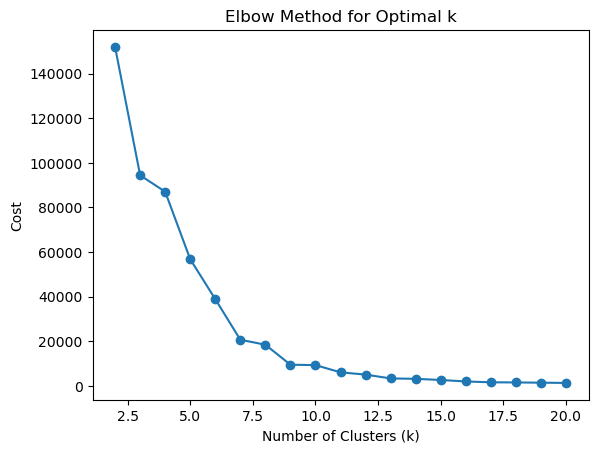

In [22]:
# Elbow Method to Find Optimal K
costs = []
for k in range(2, 21):
    kmeans = KMeans(k=k, seed=1, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    costs.append(model.summary.trainingCost)

plt.plot(range(2, 21), costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

In [23]:
# # KMeans Clustering (using the optimal k from the elbow method)
# optimal_k = 10  # Example optimal k value
# kmeans = KMeans(k=optimal_k, seed=1, featuresCol="pca_features")
# model = kmeans.fit(df_pca)
# df_clustered = model.transform(df_pca)

In [24]:
import numpy as np
def recommend_papers(title, top_n=5):
  # Assuming df_clustered is a pandas DataFrame
  paper_cluster = df_clustered[df_clustered["title"] == title]["prediction"].iloc[0]
  cluster_papers = df_clustered[df_clustered["prediction"] == paper_cluster]
  paper_features = df_clustered[df_clustered["title"] == title]["pca_features"].iloc[0]

  similarities = []
  for _, row in cluster_papers.iterrows():
    other_title = row["Dynamic analysis"]
    other_features = row["pca_features"]
    similarity = cosine_similarity(paper_features, other_features)
    similarities.append((other_title, similarity))

  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities[:top_n]
